<a href="https://colab.research.google.com/github/LanguageExchanger/TimeSeries/blob/main/DataLabelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the Ethereum price data from the uploaded CSV file
file_path = "/content/sub_upbit_eth_min_tick.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378439 entries, 0 to 378438
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    378439 non-null  object 
 1   open    378438 non-null  float64
 2   high    378438 non-null  float64
 3   low     378438 non-null  float64
 4   close   378438 non-null  float64
 5   volume  378438 non-null  float64
dtypes: float64(5), object(1)
memory usage: 17.3+ MB


(None,
                   time      open      high       low     close     volume
 0  2017-09-25 03:00:00  324500.0  325500.0  322000.0  324000.0  52.477251
 1  2017-09-25 03:01:00  324000.0  324000.0  322500.0  324000.0  39.061889
 2  2017-09-25 03:02:00  322500.0  324500.0  322500.0  324500.0  12.794000
 3  2017-09-25 03:05:00  324000.0  324000.0  323000.0  324000.0  33.365246
 4  2017-09-25 03:06:00  324000.0  325000.0  322500.0  324000.0  46.224544)

✅ Step 1: Return Threshold Banding

* 목표: 일정 시간(예: h = 60분) 후 수익률 계산
* 수익률이 +1% 초과 → Label = 1
* 수익률이 -1% 미만 → Label = 0
* 그 사이는 Label 없음 (제외)

In [ ]:
# Convert 'time' to datetime and sort
df['time'] = pd.to_datetime(df['time'], format='mixed')
df = df.sort_values('time').reset_index(drop=True)

# Parameters
horizon = 60  # lookahead horizon in minutes
threshold = 0.01  # ±1% threshold

# Compute forward returns using close prices
df['future_close'] = df['close'].shift(-horizon)
df['return'] = (df['future_close'] - df['close']) / df['close']

# Labeling
def label_return(r, th=threshold):
    if r > th:
        return 1
    elif r < -th:
        return 0
    else:
        return None  # ambiguous zone

df['label'] = df['return'].apply(label_return)

# 결과 요약: 라벨 분포 확인
label_counts = df['label'].value_counts(dropna=False)
label_counts


,count
label,
NaN,266745
1.0,56994
0.0,54700


✅ 라벨 분포 결과 (60분 후 수익률 기준 ±1% band 사용)

| 라벨    | 의미          | 샘플 수     | 비율      |
| ----- | ----------- | -------- | ------- |
| `1.0` | +1% 이상 상승   | 56,994건 | 약 10.5% |
| `0.0` | -1% 이하 하락   | 54,700건 | 약 10.2% |
| `NaN` | ±1% 사이 (제외) | 266,745건 | 약 79.3% |


🔍 해석
* 대부분의 시점에서는 ±1% 이내의 변동만 발생했기 때문에, 해당 라벨은 제외되었어.
* 이렇게 하면 모델이 의미 있는 등락만 학습하게 되고, 노이즈가 줄어들게 돼.
* 하지만 데이터의 80% 가까이 제외되므로 이후 모델 학습 시에는 충분한 샘플 수 확보를 위한 추가 전략이 필요할 수 있어 (예: 라벨 윈도우 다변화, 다중 시계 범위).

<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-4c8801492623>:20: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-inpu

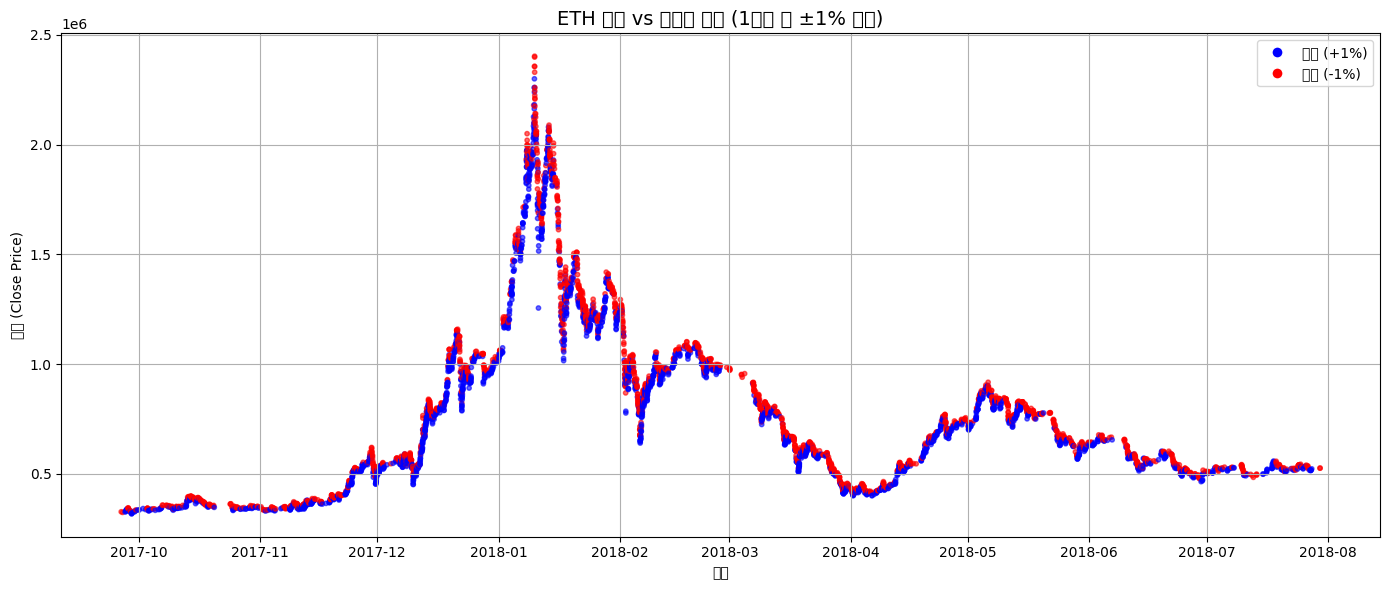

In [4]:
import matplotlib.pyplot as plt

# 시각화를 위한 샘플 데이터만 사용 (전체 100만건은 너무 많음)
sample_df = df.dropna(subset=['label']).sample(n=5000, random_state=42).sort_values('time')

# 색상 매핑: 상승(1.0)은 파랑, 하락(0.0)은 빨강
colors = sample_df['label'].map({1.0: 'blue', 0.0: 'red'})

# 산점도 그래프
plt.figure(figsize=(14, 6))
plt.scatter(sample_df['time'], sample_df['close'], c=colors, alpha=0.6, s=10)
plt.title('ETH 가격 vs 라벨링 결과 (1시간 후 ±1% 기준)', fontsize=14)
plt.xlabel('시간')
plt.ylabel('종가 (Close Price)')
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='상승 (+1%)', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='하락 (-1%)', markerfacecolor='red', markersize=8)
])
plt.tight_layout()
plt.show()
